In [1]:

import pandas as pd
import numpy as np

from datetime import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import  f1_score, recall_score, precision_score, confusion_matrix

from pprint import pprint
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import *

# Homemade functions required
from data_prep_functions import *

In [3]:
############# EDIT, FILL IN DATA HERE ############
data_file = 'Mass Spec and Protein Details FBS Int Raz.xlsx'  #excel sheet path, excel sheet example in data

CMNP200_prop_sheet = 'Protein Properties' #sheet name of excel sheet containing protein properties
CMNP200_mass_spec_sheet = 'Mass Spec Details' #sheet name of excel sheet containing mass spec data

netsurfp_data = pd.read_excel("data/"+'FBS_int_raz_netsurfp_processed.xlsx') #excel sheet with worked up netsurfp data from prep for netsurfp script
###################################################
############ NO EDITS REQUIRED ##############
data_filepath = "data/"+data_file
# load data

CMNP200_raw_prop_data = pd.read_excel(data_filepath, sheet_name= CMNP200_prop_sheet, thousands=',')
CMNP200_raw_mass_spec_data = pd.read_excel(data_filepath, sheet_name=CMNP200_mass_spec_sheet, header=0)

#clean up and calculate % protein abundance and enrichment, function found in data_prep_functions line 470

CMNP200_mass_spec_data_clean = clean_up_data_mass_spec(CMNP200_raw_mass_spec_data)
Accesions_IDs = CMNP200_mass_spec_data_clean["Accession"].to_frame()

# clean up protein data, fucntion found in data_prep_functions.py line 367

CMNP200_cleaned_data = clean_up_data_biopy(CMNP200_raw_prop_data, Accesions_IDs) #calculates biopython features from protein sequences, and removes proteins removed during mass spec clean up

CMNP200_cleaned_data = normalize_mass_length_1DF(CMNP200_cleaned_data) #function found in data_prep_functions line 167, normalizes mass, length and mw by dividing all values by the max in the column

CMNP200_complete_data = pd.merge(CMNP200_cleaned_data, netsurfp_data, left_on='Entry', right_on='entry') #merges netsurfp features and biopython features


#creates new column called asa_sum_normalized which is the asa_sum value divide by the mass of the protein
for df in [CMNP200_complete_data]:
    for col in ['asa_sum']:
        df[col+'_normalized'] = df[col] / df['Mass']


## Training Models and Classification

there are three ways to classify in corona versus out of corona here. 1) landry classifer 2) split classifer and 3) psudeo abundance thresholding
for 1 and 2 run graphing script at end, 3 has graphing already integrated

## anything that says ignore is left over code/useless code from when they use to run 2 serums at a time, needs to be further cleaned (only commented one classifer since they all share same code except for classification part

In [6]:
### Landry Classifer

trials = 100 #number of models per threshold power
first_frame = True #starting dataframe for saving metrics
correctness_frame = pd.DataFrame()
metrics_frame = pd.DataFrame()
print_metrics = 0 #0, doesn't show metrics while runnning for each model, 1 does show metrics

for thresh_power in np.arange(1,3.6,.25): #loop for training 100 models for each power
    print('Power ', thresh_power)
    fluids_type_list=['CMNP200'] #ignore
    CMNP200_labels = CMNP200_mass_spec_data_clean[['Accession', 'NP_%_Abundance','Enrichment','FBS Relative Abundance']].copy() #makes copy of mass spec data
    data_sheets = [CMNP200_labels]#ignore
    #fit data to distribution, ignore for loop part
    x = np.arange(0,1,.01)
    for k in range(1):
        sheet = data_sheets[k] #ignore
        fluid_type = fluids_type_list[k]#ignore

        print(f'\n{fluid_type.capitalize()} running')

        num_proteins = np.zeros(100)
        for i in np.arange(0,100,1):
            thresh = i/100
            index = (sheet['NP_%_Abundance']>thresh)
            num_proteins[i] = (np.count_nonzero(index))


        num_proteins_above_1_abundance = min(num_proteins)
        biexponent_dist = num_proteins - num_proteins_above_1_abundance
        num_protein_thresh = np.max(biexponent_dist)/pow(np.e,thresh_power)
        cutoff_thresh_value = min(x[(biexponent_dist<num_protein_thresh)&(biexponent_dist>0)], default=0)
        #classifer
        sheet['Corona'] = ((sheet['NP_%_Abundance']>cutoff_thresh_value) | (sheet['Enrichment']>1)).astype(int)
        #percent of protein classifed as in corona
        print(sheet['Corona'].sum()/sheet['Corona'].shape[0])
    #drop uneeded columns
    CMNP200_labels = CMNP200_labels.drop(['NP_%_Abundance', 'Enrichment', 'FBS Relative Abundance'], axis=1)



    # function found in data prep functions.py line 827, if there are multiple accession numbers associated with single protein expands that into multiple row entries
    CMNP200_labels = accession_expansion(CMNP200_labels)

    #merge in/out of corona labels and features
    CMNP200_total_data_names = pd.merge(CMNP200_labels, CMNP200_complete_data.copy(), left_on='Accession', right_on='Entry')
    #drop unneeded columns
    CMNP200_total_data_names =CMNP200_total_data_names.drop(['Accession','Entry', 'entry', 'Sequence', 'Length', 'Mass'], axis=1)

    #make a copy of just features
    features_CMNP200 = CMNP200_total_data_names.copy()
    features_CMNP200 = features_CMNP200.drop(['Corona'], axis=1)
    #make copy of just labels
    names_CMNP200 = CMNP200_total_data_names['Corona'].copy()
    #ignore
    features_merged_naive = features_CMNP200
    names_merged = names_CMNP200

    #normalize dataset with min/max scaling
    scaler = MinMaxScaler()

    #make copy of features
    total_data = features_merged_naive.copy()
    total_data = total_data.fillna(0)
    total_data = total_data.drop(['Protein names'], axis=1)

    #fit scaler to data
    scaler = scaler.fit(total_data)
    scaled_df = pd.DataFrame(scaler.transform(total_data), columns=total_data.columns)

    #ignore
    names = names_merged.copy()


    #ignore
    df = scaled_df.copy()
    labels = names
    #make data frame for feature importances
    feature_imp = pd.DataFrame(columns=list(scaled_df.columns))

    i = 0
    #split data into text and train n times
    sss = StratifiedShuffleSplit(n_splits=trials, test_size=0.1, random_state=2016)
    for train_index, test_index in sss.split(df, labels):
        X_train = df.iloc[train_index]
        X_test = df.iloc[test_index]
        y_train = labels.iloc[train_index]
        y_test = labels.iloc[test_index]
        k = i
        #syntheic oversampling
        sme = SMOTE(sampling_strategy=1, random_state=i, n_jobs=-1, k_neighbors=12)
        X_train_oversampled, y_train_oversampled = sme.fit_resample(X_train, y_train)

        # Create and Train
        rfc=RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=i, n_estimators=100)
        rfc.fit(X_train_oversampled,y_train_oversampled)

        #everyting below is for saving meteric of each model trained
        if first_frame:  # Initialize
            first_frame = False  # Don't Come back Here

            datadict = {'true':y_test.to_numpy(), 'estimate':rfc.predict(X_test), 'probability':rfc.predict_proba(X_test)[:, 1]}

            correctness_frame = pd.DataFrame(data=datadict)
            correctness_frame['round'] = i

            metrics_dict = {'AUC':metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]),
            'Accuracy':rfc.score(X_test, y_test), 'Recall':recall_score(y_test, rfc.predict(X_test)),
            'Precision':precision_score(y_test, rfc.predict(X_test), zero_division=0), 'F1':f1_score(y_test, rfc.predict(X_test))}

            metrics_frame = pd.DataFrame.from_dict(data=metrics_dict,orient='index').transpose()
            metrics_frame['round'] = i
            metrics_frame['Threshold Power'] = thresh_power

            if print_metrics == 1:
                print('Round:', i)
                print('Correctness Frame')
                print(correctness_frame)
                print('Metrics Frame')
                print(metrics_frame)


        else:
            datadict = {'true':y_test.to_numpy(), 'estimate':rfc.predict(X_test), 'probability':rfc.predict_proba(X_test)[:, 1]}
            revolve_frame = pd.DataFrame(data=datadict)
            revolve_frame['round'] = i
            correctness_frame = pd.concat([correctness_frame,revolve_frame], ignore_index=True, axis=0)

            metrics_dict = {'AUC':metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]),
            'Accuracy':rfc.score(X_test, y_test), 'Recall':recall_score(y_test, rfc.predict(X_test)),
            'Precision':precision_score(y_test, rfc.predict(X_test), zero_division=0), 'F1':f1_score(y_test, rfc.predict(X_test))}
            metrics_revolve_frame = pd.DataFrame.from_dict(data=metrics_dict, orient='index').transpose()
            metrics_revolve_frame['round'] = i
            metrics_revolve_frame['Threshold Power'] = thresh_power

            metrics_frame = pd.concat([metrics_frame,metrics_revolve_frame], ignore_index=True, axis=0)

            if print_metrics == 1:
                print("Round:", i)
                print("Correctness Frame")
                print(revolve_frame)
                print('Metrics')
                print(metrics_revolve_frame)


        i += 1


        feature_imp.loc[i] = pd.Series(rfc.feature_importances_,index=list(df.columns))

Power  1.0

Cmnp200 running
0.5833333333333334
Power  1.25

Cmnp200 running
0.5277777777777778
Power  1.5

Cmnp200 running
0.5
Power  1.75

Cmnp200 running
0.4583333333333333
Power  2.0

Cmnp200 running
0.4444444444444444
Power  2.25

Cmnp200 running
0.4166666666666667


/Users/gustavo/PycharmProjects/swnt-protein-corona-ML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gustavo/PycharmProjects/swnt-protein-corona-ML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gustavo/PycharmProjects/swnt-protein-corona-ML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Power  2.5

Cmnp200 running
0.4027777777777778


/Users/gustavo/PycharmProjects/swnt-protein-corona-ML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gustavo/PycharmProjects/swnt-protein-corona-ML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gustavo/PycharmProjects/swnt-protein-corona-ML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Power  2.75

Cmnp200 running
0.3888888888888889


/Users/gustavo/PycharmProjects/swnt-protein-corona-ML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gustavo/PycharmProjects/swnt-protein-corona-ML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gustavo/PycharmProjects/swnt-protein-corona-ML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Power  3.0

Cmnp200 running
0.3888888888888889


/Users/gustavo/PycharmProjects/swnt-protein-corona-ML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gustavo/PycharmProjects/swnt-protein-corona-ML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gustavo/PycharmProjects/swnt-protein-corona-ML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Power  3.25

Cmnp200 running
0.375


/Users/gustavo/PycharmProjects/swnt-protein-corona-ML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gustavo/PycharmProjects/swnt-protein-corona-ML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gustavo/PycharmProjects/swnt-protein-corona-ML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Power  3.5

Cmnp200 running
0.375


/Users/gustavo/PycharmProjects/swnt-protein-corona-ML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gustavo/PycharmProjects/swnt-protein-corona-ML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gustavo/PycharmProjects/swnt-protein-corona-ML/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [4]:


## Split Classifer


trials = 100
first_frame = True
correctness_frame = pd.DataFrame()
metrics_frame = pd.DataFrame()
print_metrics = 0

for thresh_power in np.arange(1,3.6,.25):
    print('Power ', thresh_power)
    fluids_type_list=['CMNP200']
    CMNP200_labels = CMNP200_mass_spec_data_clean[['Accession', 'NP_%_Abundance','Enrichment','FBS Relative Abundance']].copy()
    data_sheets = [CMNP200_labels]
    x = np.arange(0,1,.01)
    for k in range(1):
        sheet = data_sheets[k]
        fluid_type = fluids_type_list[k]

        print(f'\n{fluid_type.capitalize()} running')

        num_proteins = np.zeros(100)
        for i in np.arange(0,100,1):
            thresh = i/100
            index = (sheet['NP_%_Abundance']>thresh)
            num_proteins[i] = (np.count_nonzero(index))


        num_proteins_above_1_abundance = min(num_proteins)
        biexponent_dist = num_proteins - num_proteins_above_1_abundance
        num_protein_thresh = np.max(biexponent_dist)/pow(np.e,thresh_power)
        cutoff_thresh_value = min(x[(biexponent_dist<num_protein_thresh)&(biexponent_dist>0)], default=0)
        psudeo_enriched_proteins = sheet.loc[sheet["FBS Relative Abundance"] < 0.044, ['Accession', 'NP_%_Abundance','Enrichment','FBS Relative Abundance']]
        non_psudeo_enriched_proteins = sheet.loc[sheet["FBS Relative Abundance"] > 0.044, ['Accession', 'NP_%_Abundance','Enrichment','FBS Relative Abundance']]
        psudeo_enriched_proteins['Corona'] = (psudeo_enriched_proteins['NP_%_Abundance']>cutoff_thresh_value).astype(int)
        non_psudeo_enriched_proteins['Corona'] = ((non_psudeo_enriched_proteins['NP_%_Abundance']>cutoff_thresh_value) | (non_psudeo_enriched_proteins['Enrichment']>1)).astype(int)
        psudeo_enriched_prot_labels = psudeo_enriched_proteins[["Accession", "Corona"]]
        non_psudeo_enriched_pro_labels = non_psudeo_enriched_proteins[["Accession", "Corona"]]
        remerged_protein_labels = pd.concat([non_psudeo_enriched_pro_labels,psudeo_enriched_prot_labels], ignore_index=True, axis=0)
        sheet = pd.merge(sheet,remerged_protein_labels, how="inner", on='Accession')
        print(sheet['Corona'].sum()/sheet['Corona'].shape[0])
        CMNP200_labels = sheet
    CMNP200_labels = CMNP200_labels.drop(['NP_%_Abundance', 'Enrichment', 'FBS Relative Abundance'], axis=1)



    # checks for any accession lists
    CMNP200_labels = accession_expansion(CMNP200_labels)


    CMNP200_total_data_names = pd.merge(CMNP200_labels, CMNP200_complete_data.copy(), left_on='Accession', right_on='Entry')

    CMNP200_total_data_names =CMNP200_total_data_names.drop(['Accession','Entry', 'entry', 'Sequence', 'Length', 'Mass'], axis=1)


    features_CMNP200 = CMNP200_total_data_names.copy()
    features_CMNP200 = features_CMNP200.drop(['Corona'], axis=1)
    names_CMNP200 = CMNP200_total_data_names['Corona'].copy()

    #rename database to match combined database name

    features_merged_naive = features_CMNP200
    names_merged = names_CMNP200
    
    scaler = MinMaxScaler()

    total_data = features_merged_naive.copy()
    total_data = total_data.fillna(0)
    total_data = total_data.drop(['Protein names'], axis=1)
    scaler = scaler.fit(total_data)
    scaled_df = pd.DataFrame(scaler.transform(total_data), columns=total_data.columns)

    names = names_merged.copy()
    


    df = scaled_df.copy()
    labels = names
    feature_imp = pd.DataFrame(columns=list(scaled_df.columns))

    i = 0
    sss = StratifiedShuffleSplit(n_splits=trials, test_size=0.1, random_state=2016)
    for train_index, test_index in sss.split(df, labels):
        X_train = df.iloc[train_index]
        X_test = df.iloc[test_index]
        y_train = labels.iloc[train_index]
        y_test = labels.iloc[test_index]
        k = i
        sme = SMOTE(sampling_strategy=1, random_state=i, n_jobs=-1, k_neighbors=12)
        X_train_oversampled, y_train_oversampled = sme.fit_resample(X_train, y_train)

        # Create and Train
        rfc=RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=i, n_estimators=100)

        rfc.fit(X_train_oversampled,y_train_oversampled)
        if first_frame:  # Initialize 
            first_frame = False  # Don't Come back Here

            datadict = {'true':y_test.to_numpy(), 'estimate':rfc.predict(X_test), 'probability':rfc.predict_proba(X_test)[:, 1]}

            correctness_frame = pd.DataFrame(data=datadict)
            correctness_frame['round'] = i

            metrics_dict = {'AUC':metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]),
            'Accuracy':rfc.score(X_test, y_test), 'Recall':recall_score(y_test, rfc.predict(X_test)), 
            'Precision':precision_score(y_test, rfc.predict(X_test), zero_division=0), 'F1':f1_score(y_test, rfc.predict(X_test))}

            metrics_frame = pd.DataFrame.from_dict(data=metrics_dict,orient='index').transpose()
            metrics_frame['round'] = i
            metrics_frame['Threshold Power'] = thresh_power

            if print_metrics == 1:
                print('Round:', i)
                print('Correctness Frame')
                print(correctness_frame)
                print('Metrics Frame')
                print(metrics_frame)


        else:
            datadict = {'true':y_test.to_numpy(), 'estimate':rfc.predict(X_test), 'probability':rfc.predict_proba(X_test)[:, 1]}
            revolve_frame = pd.DataFrame(data=datadict)
            revolve_frame['round'] = i
            correctness_frame = pd.concat([correctness_frame,revolve_frame], ignore_index=True, axis=0)

            metrics_dict = {'AUC':metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]),
            'Accuracy':rfc.score(X_test, y_test), 'Recall':recall_score(y_test, rfc.predict(X_test)), 
            'Precision':precision_score(y_test, rfc.predict(X_test), zero_division=0), 'F1':f1_score(y_test, rfc.predict(X_test))}
            metrics_revolve_frame = pd.DataFrame.from_dict(data=metrics_dict, orient='index').transpose()
            metrics_revolve_frame['round'] = i
            metrics_revolve_frame['Threshold Power'] = thresh_power
            
            metrics_frame = pd.concat([metrics_frame,metrics_revolve_frame], ignore_index=True, axis=0)

            if print_metrics == 1:
                print("Round:", i)
                print("Correctness Frame")
                print(revolve_frame)
                print('Metrics')
                print(metrics_revolve_frame)
    

        i += 1


        feature_imp.loc[i] = pd.Series(rfc.feature_importances_,index=list(df.columns))





Power  1.0

Cmnp200 running
0.5833333333333334


KeyboardInterrupt: 

In [ ]:
###psuedo abundance thresholding classifer

trials = 100
first_frame = True
correctness_frame = pd.DataFrame()
metrics_frame = pd.DataFrame()
print_metrics = 0

##generate thresholding list for psuedo abudances

abudance_list = []
temp_df = CMNP200_raw_mass_spec_data.copy()
temp_df.loc[temp_df['FBS Relative Abundance'] == 0.0431998478815122, 'FBS Relative Abundance'] = np.nan
min_abundance = temp_df["FBS Relative Abundance"].min()

for i in range(1,9,1):
    i = i*0.1
    abudance_list.append(min_abundance*i)

First_Pass = True
y = 0

for j in abudance_list:

    if First_Pass == True:
        temp_df['FBS Relative Abundance'] = temp_df['FBS Relative Abundance'].replace(np.nan, j)
        CMNP200_mass_spec_data_clean = clean_up_data_mass_spec(temp_df)
        First_Pass = False
    else:
        temp_df['FBS Relative Abundance'] = temp_df['FBS Relative Abundance'].replace(abudance_list[y], j)
        CMNP200_mass_spec_data_clean = clean_up_data_mass_spec(temp_df)
        y = y + 1

    print('Abundance Threshold', round(j,3))

    for thresh_power in np.arange(1,3.6,.25):
        print('Power ', thresh_power)
        fluids_type_list=['CMNP200']
        CMNP200_labels = CMNP200_mass_spec_data_clean[['Accession', 'NP_%_Abundance','Enrichment','FBS Relative Abundance']].copy()
        data_sheets = [CMNP200_labels]
        x = np.arange(0,1,.01)
        for k in range(1):
            sheet = data_sheets[k]
            fluid_type = fluids_type_list[k]

            print(f'\n{fluid_type.capitalize()} running')

            num_proteins = np.zeros(100)
            for i in np.arange(0,100,1):
                thresh = i/100
                index = (sheet['NP_%_Abundance']>thresh)
                num_proteins[i] = (np.count_nonzero(index))


            num_proteins_above_1_abundance = min(num_proteins)
            biexponent_dist = num_proteins - num_proteins_above_1_abundance
            num_protein_thresh = np.max(biexponent_dist)/pow(np.e,thresh_power)
            cutoff_thresh_value = min(x[(biexponent_dist<num_protein_thresh)&(biexponent_dist>0)], default=0)
            sheet['Corona'] = ((sheet['NP_%_Abundance']>cutoff_thresh_value) | (sheet['Enrichment']>1)).astype(int)
            print(sheet['Corona'].sum()/sheet['Corona'].shape[0])
        CMNP200_labels = CMNP200_labels.drop(['NP_%_Abundance', 'Enrichment', 'FBS Relative Abundance'], axis=1)



        # checks for any accession lists
        CMNP200_labels = accession_expansion(CMNP200_labels)


        CMNP200_total_data_names = pd.merge(CMNP200_labels, CMNP200_complete_data.copy(), left_on='Accession', right_on='Entry')

        CMNP200_total_data_names =CMNP200_total_data_names.drop(['Accession','Entry', 'entry', 'Sequence', 'Length', 'Mass'], axis=1)


        features_CMNP200 = CMNP200_total_data_names.copy()
        features_CMNP200 = features_CMNP200.drop(['Corona'], axis=1)
        names_CMNP200 = CMNP200_total_data_names['Corona'].copy()

        #rename database to match combined database name

        features_merged_naive = features_CMNP200
        names_merged = names_CMNP200

        scaler = MinMaxScaler()

        total_data = features_merged_naive.copy()
        total_data = total_data.fillna(0)
        total_data = total_data.drop(['Protein names'], axis=1)
        scaler = scaler.fit(total_data)
        scaled_df = pd.DataFrame(scaler.transform(total_data), columns=total_data.columns)

        names = names_merged.copy()



        df = scaled_df.copy()
        labels = names
        feature_imp = pd.DataFrame(columns=list(scaled_df.columns))

        i = 0
        sss = StratifiedShuffleSplit(n_splits=trials, test_size=0.1, random_state=2016)
        for train_index, test_index in sss.split(df, labels):
            X_train = df.iloc[train_index]
            X_test = df.iloc[test_index]
            y_train = labels.iloc[train_index]
            y_test = labels.iloc[test_index]
            k = i
            sme = SMOTE(sampling_strategy=1, random_state=i, n_jobs=-1, k_neighbors=12)
            X_train_oversampled, y_train_oversampled = sme.fit_resample(X_train, y_train)

            # Create and Train
            rfc=RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=i, n_estimators=100)

            rfc.fit(X_train_oversampled,y_train_oversampled)
            if first_frame:  # Initialize
                first_frame = False  # Don't Come back Here

                datadict = {'true':y_test.to_numpy(), 'estimate':rfc.predict(X_test), 'probability':rfc.predict_proba(X_test)[:, 1]}

                correctness_frame = pd.DataFrame(data=datadict)
                correctness_frame['round'] = i

                metrics_dict = {'AUC':metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]),
                'Accuracy':rfc.score(X_test, y_test), 'Recall':recall_score(y_test, rfc.predict(X_test)),
                'Precision':precision_score(y_test, rfc.predict(X_test)), 'F1':f1_score(y_test, rfc.predict(X_test))}

                metrics_frame = pd.DataFrame.from_dict(data=metrics_dict,orient='index').transpose()
                metrics_frame['round'] = i
                metrics_frame['Threshold Power'] = thresh_power

                if print_metrics == 1:
                    print('Round:', i)
                    print('Correctness Frame')
                    print(correctness_frame)
                    print('Metrics Frame')
                    print(metrics_frame)


            else:
                datadict = {'true':y_test.to_numpy(), 'estimate':rfc.predict(X_test), 'probability':rfc.predict_proba(X_test)[:, 1]}
                revolve_frame = pd.DataFrame(data=datadict)
                revolve_frame['round'] = i
                correctness_frame = pd.concat([correctness_frame,revolve_frame], ignore_index=True, axis=0)

                metrics_dict = {'AUC':metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]),
                'Accuracy':rfc.score(X_test, y_test), 'Recall':recall_score(y_test, rfc.predict(X_test)),
                'Precision':precision_score(y_test, rfc.predict(X_test)), 'F1':f1_score(y_test, rfc.predict(X_test))}
                metrics_revolve_frame = pd.DataFrame.from_dict(data=metrics_dict, orient='index').transpose()
                metrics_revolve_frame['round'] = i
                metrics_revolve_frame['Threshold Power'] = thresh_power
                metrics_frame = pd.concat([metrics_frame,metrics_revolve_frame], ignore_index=True, axis=0)

                if print_metrics == 1:
                    print("Round:", i)
                    print("Correctness Frame")
                    print(revolve_frame)
                    print('Metrics')
                    print(metrics_revolve_frame)


            i += 1


            feature_imp.loc[i] = pd.Series(rfc.feature_importances_,index=list(df.columns))

    plt.close("all")
    short_description = "PsuedoAbundanceThresholding" + str(round(j,3))
    png_filepath = log_metrics_data(metrics_frame,short_description)

    plt.rcParams.update({'font.size': 16})
    total_metrics_df_melted = pd.melt(metrics_frame, id_vars=['Threshold Power', 'round'], value_vars=['Accuracy', 'AUC', 'Precision', 'Recall'],
                                  var_name='Metric', value_name='Mean')
    # total_metrics_df_melted.head()
    fig = plt.figure(figsize=(16,12))
    ax = sns.lineplot(data=total_metrics_df_melted, x="Threshold Power", y="Mean", hue="Metric", palette=['#4448FB', '#3DA5E3', "#50FAD0", '#3DE34E'])

    ax.set_ylabel('Mean', fontsize=22)
    ax.set_xlabel('Threshold Power', fontsize=22)
    plt.savefig(png_filepath)





## Graphing Script, graphs average Accuracy, AUC, Precision and Recall as a function of threshold power
also automatically saves metric dataframe and graph as png bases on time and date + short description

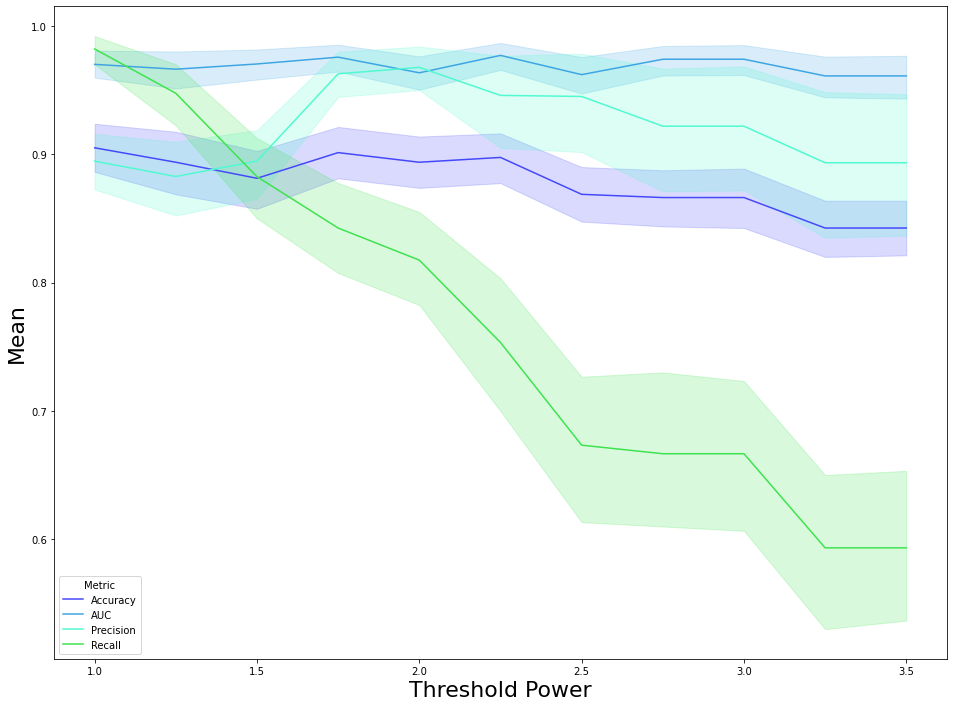

In [7]:
# save data with time, date and description
plt.close("all")
short_description = "FBS_int_raz"
png_filepath = log_metrics_data(metrics_frame,short_description)

plt.rcParams.update({'font.size': 16})
total_metrics_df_melted = pd.melt(metrics_frame, id_vars=['Threshold Power', 'round'], value_vars=['Accuracy', 'AUC', 'Precision', 'Recall'],
                                  var_name='Metric', value_name='Mean')
# total_metrics_df_melted.head()
fig = plt.figure(figsize=(16,12))
ax = sns.lineplot(data=total_metrics_df_melted, x="Threshold Power", y="Mean", hue="Metric", palette=['#4448FB', '#3DA5E3', "#50FAD0", '#3DE34E'])

ax.set_ylabel('Mean', fontsize=22)
ax.set_xlabel('Threshold Power', fontsize=22)
plt.savefig(png_filepath)